In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

# SELLER P&L ANALYSIS

🎯 The goal of this exercise is to compute the P&L associated to each seller  

For each `seller_id` we need three items:  

- The **revenue**:
 - 10% fee on sales
 - 80 BRL per month on Olist


- The **cost**:
 - Review cost according to `{1: 100, 2: 50, 3: 40, 4: 0, 5: 0}` with review score as key and cost in BRL as value


- The **profit** made by Olist

💡 Let's not start from scratch  
❓ Import your seller training set and investigate what you already have.


In [ ]:
from olist.seller import Seller
seller = Seller()

In [ ]:
sellers = seller.get_training_data()
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,share_of_one_stars,share_of_five_stars,review_score
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000,218.70,0.333333,0.333333,3.00
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,1.025,11703.07,0.050000,0.725000,4.55
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,1,1,1.000,158.00,0.000000,1.000000,5.00
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,1,1,1.000,79.99,0.000000,1.000000,5.00
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1,1,1.000,167.99,1.000000,0.000000,1.00


❓ What is missing?  
Write down a strategy to get your missing columns  
Re-use as much of what has already been coded in `seller.py` as possible

In [ ]:
# Your pseudo-code

❓ Make a copy of `seller.py`, rename it `seller_updated.py` and update it accordingly

Correction below is equivalent to the `get_review_score` method in `seller_updated.py`

Show students how to update their code and print results in their notebook  
Debug using `breakpoint()` when needed

```python
def get_review_score(self):
    """
    Returns a DataFrame with:
    'seller_id', 'share_of_five_stars', 'share_of_one_stars', 'review_score', 'cost_of_reviews'
    """

    orders_reviews = self.order.get_review_score()
    orders_sellers = self.data['order_items'][['order_id', 'seller_id'
                                               ]].drop_duplicates()

    df = orders_sellers.merge(orders_reviews, on='order_id')

    df['cost_of_review'] = df.review_score.map({
        1: 100,
        2: 50,
        3: 40,
        4: 0,
        5: 0
    })

    df_grouped_by_sellers = df.groupby('seller_id', as_index=False).agg({
        'dim_is_one_star':
        'mean',
        'dim_is_five_star':
        'mean',
        'review_score':
        'mean',
        'cost_of_review':
        'sum'
    })
    df_grouped_by_sellers.columns = [
        'seller_id', 'share_of_one_stars', 'share_of_five_stars',
        'review_score', 'cost_of_reviews'
    ]

    return df_grouped_by_sellers
```

❓ Compute seller profits

```python
def get_training_data(self):
    """
    Returns a DataFrame with:
    ['seller_id', 'seller_city', 'seller_state', 'delay_to_carrier',
    'wait_time', 'date_first_sale', 'date_last_sale', 'months_on_olist',
    'share_of_one_stars', 'share_of_five_stars', 'review_score',
    'cost_of_reviews', 'n_orders', 'quantity', 'quantity_per_order',
    'sales', 'revenues', 'profits']
    """
    training_set =\
        self.get_seller_features()\
            .merge(
            self.get_seller_delay_wait_time(), on='seller_id'
        ).merge(
            self.get_active_dates(), on='seller_id'
        ).merge(
            self.get_review_score(), on='seller_id'
        ).merge(
            self.get_quantity(), on='seller_id'
        ).merge(
            self.get_sales(), on='seller_id'
        )

    # Add seller economics (revenues, profits)
    olist_monthly_fee = 80
    olist_sales_cut = 0.1

    training_set['revenues'] = training_set['months_on_olist'] * olist_monthly_fee\
        + olist_sales_cut * training_set['sales']

    training_set['profits'] = training_set['revenues'] - training_set[
        'cost_of_reviews']

    return training_set
```

❓ Load your updated DataFrame

In [ ]:
from olist.seller_updated import Seller as SellerUpdated
sellers = SellerUpdated().get_training_data()

❓ Sort sellers by profit, and analyse their profitability: conclude on a possible strategy for Olist!

Text(0.5, 0, 'seller id')

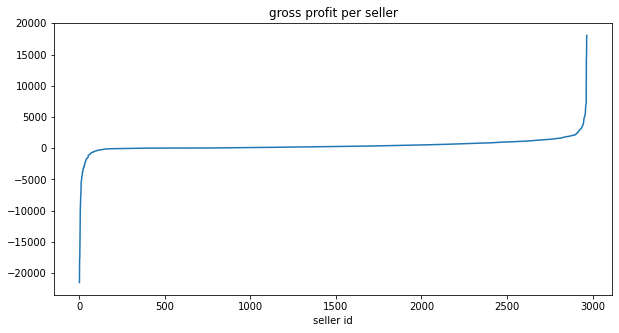

In [ ]:
sorted_sellers = sellers.sort_values(by='profits')[['profits', 'n_orders', 'revenues']].reset_index()
sorted_sellers.head()

plt.figure(figsize=(10,5))
sorted_sellers.profits.plot()
plt.title('gross profit per seller')
plt.xlabel('seller id')